# Soil Heat‑Flux Estimation & Validation  
This notebook demonstrates how to derive **surface ground‑heat flux (G₀)** from a SoilVUE profile using the helper functions included in the project repository, and then compares the derived values with the *in‑situ* heat‑flux‑plate measurements (“G”) available in the eddy‑covariance flux file.

Data files used:

| File | Contents | Native resolution |
|------|----------|-------------------|
| `21026_Statistics_AmeriFlux0.dat` | SoilVUE profile statistics (T, VWC, κ etc.) | Site‑logger native (≈ 5–10 min) |
| `21025_Flux_AmeriFluxFormat_30.dat` | 30‑min AmeriFlux‑format flux file (includes **G**) | 30 min |

The analysis proceeds as follows:

1. **Load & tidy** the two datasets.  
2. **Estimate** ground‑heat flux from the SoilVUE temperatures and soil‑moisture–dependent conductivity using `soil_heat.compute_heat_flux_conduction`.  
3. **Merge** the estimated series with the measured 30‑min “G” record.  
4. **Evaluate** performance using RMSE & NME (functions in `gao_et_al.py`) and quick visualisations.

> **Note** – The SoilVUE statistics file shipped with this example has a single timestamp header (`2024‑07‑11`).  Rows are therefore back‑filled with that value and treated as measurements for **11 July 2024**.  If your logger exports full timestamps, simply remove the forward‑fill block below.


## Import relevant libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Project helper modules (all live in /mnt/data after upload)
sys.path.append('../../src')
import soil_heat                     # gradient & calorimetric methods
#import gao_et_al as gao              # RMSE & NME helpers


In [16]:
station_path = Path("G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/")

## Load SoilVUE Data

In [17]:
# ---------- SoilVUE data ----------------------------------------------------
soilvue_path_1 = station_path / "m20250513/21031_Statistics_AmeriFlux38.dat"
soilvue_path_2 = station_path / "m20250513/21031_Statistics_AmeriFlux39.dat"

# Combine the two SoilVUE files into one DataFrame
df_sv_1 = pd.read_csv(
    soilvue_path_1,
    na_values=['NAN'],
    engine='python',
)
df_sv_2 = pd.read_csv(
    soilvue_path_2,
    na_values=['NAN'],
    engine='python',
)

# Use the Python CSV engine for robust parsing (mixed quoting, many columns)
df_sv = pd.concat([df_sv_1, df_sv_2], ignore_index=True)

# Back‑fill the one timestamp so that every row carries a datetime label
df_sv['TIMESTAMP_START'] = df_sv['TIMESTAMP_START'].ffill()

# Parse to pandas datetime (format YYYYMMDDhhmm)
df_sv['datetime'] = pd.to_datetime(df_sv['TIMESTAMP_START'], format='%Y%m%d%H%M')

# For this demo we keep only the channels needed for the gradient method
df_sv = df_sv.astype({'T_1_1_1': float,
                      'T_1_2_1': float,
                        'T_1_3_1': float,
                        'T_1_4_1': float,
                        'T_1_5_1': float,
                        'T_1_6_1': float,
                        'T_1_7_1': float,
                      'VWC_1_1_1': float,
                      'VWC_1_2_1': float,
                        'VWC_1_3_1': float,
                        'VWC_1_4_1': float,
                        'VWC_1_5_1': float,
                        'VWC_1_6_1': float,
                        'VWC_1_7_1': float,
                        'T_CANOPY': float, 
                        'NETRAD': float,
                        'SW_IN': float,
                        'SW_OUT': float,
                        'LW_IN': float,
                        'LW_OUT': float,
                      })


In [ ]:


#df_sv['datetime'] = pd.date_range(start='2024-07-11 05:30', periods=589, freq='30min')
# Package expects the DataFrame columns to be named explicitly
df_grad =df_sv.rename(columns={
    'T_CANOPY':'T00cm',
    'T_1_1_1':'T05cm',
    'T_1_2_1':'T10cm',
    'T_1_3_1':'T20cm',
    'T_1_4_1':'T30cm',
    'T_1_5_1':'T40cm',
    'T_1_6_1':'T50cm',
    'T_1_7_1':'T60cm', 
    'VWC_1_1_1':'VWC05cm',
    'VWC_1_2_1':'VWC10cm',
    'VWC_1_3_1':'VWC20cm',
    'VWC_1_4_1':'VWC30cm',
    'VWC_1_5_1':'VWC40cm',
    'VWC_1_6_1':'VWC50cm',
    'VWC_1_7_1':'VWC60cm',
}).set_index('datetime')



## Plot SoilVUE data

Include data from the SI-111, which is technically measuring Temperature of the canopy top, but is T0cm for the timeframe being examined.

<Axes: title={'center': 'SoilVUE temperatures'}, xlabel='datetime'>

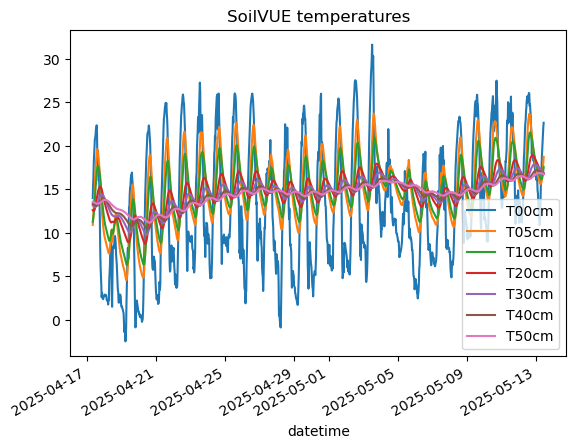

In [19]:
df_grad[['T00cm','T05cm', 'T10cm', 'T20cm', 'T30cm','T40cm','T50cm']].plot(title='SoilVUE temperatures')

## Initial Estimate of G0

In [ ]:
# ---------- Parameters ------------------------------------------------------
DEPTH_TOP  = 0.05   # m  (sensor 1)
DEPTH_LOW  = 0.10   # m  (sensor 2)

# ---- Call helper – returns a pd.Series (W m‑2, positive downward)
G0_est = soil_heat.compute_heat_flux_conduction(
    df_grad,
    depth1=DEPTH_TOP,
    depth2=DEPTH_LOW,
    col_T1='T05cm',
    col_T2='T10cm',
    col_theta1='VWC05cm',
    col_theta2='VWC10cm',
    porosity = 0.5,
    k_dry = 0.45,
    k_sat = 2
)

G0_est_2 = soil_heat.compute_heat_flux_calorimetric(df_grad,depth_levels=[0.05,0.1,0.2,0.3],T_cols=['T05cm', 'T10cm','T20cm','T30cm'],theta_cols=['VWC05cm', 'VWC10cm', 'VWC20cm', 'VWC30cm'], )



## Calculate amplitude and lag of data

In [20]:
amp_values = pd.concat([soil_heat.diurnal_amplitude(df_grad['T00cm']),
                        soil_heat.diurnal_amplitude(df_grad['T05cm']),
                        soil_heat.diurnal_amplitude(df_grad['T10cm']),
                        soil_heat.diurnal_amplitude(df_grad['T20cm']),
                        soil_heat.diurnal_amplitude(df_grad['T30cm']),
],axis=1).round(2).rename(columns={
    'T00cm':'T00cm_amp',
    'T05cm':'T05cm_amp',
    'T10cm':'T10cm_amp',
    'T20cm':'T20cm_amp',
    'T30cm':'T30cm_amp',
})

amp_values

,T00cm_amp,T05cm_amp,T10cm_amp,T20cm_amp,T30cm_amp
datetime,,,,,
2025-04-17,19.99,9.52,6.43,2.77,1.48
2025-04-18,8.48,4.85,2.92,2.75,2.36
2025-04-19,19.40,11.01,7.58,3.06,1.67
2025-04-20,22.57,14.12,10.10,4.64,2.68
2025-04-21,23.12,13.28,9.43,4.36,2.59
2025-04-22,22.22,12.51,8.80,3.99,2.34
2025-04-23,21.82,10.65,7.50,3.44,2.00
2025-04-24,21.24,11.02,7.58,3.38,1.92
2025-04-25,18.99,10.52,7.14,3.19,1.80


In [21]:
diff_00_10 = soil_heat.thermal_diffusivity_amplitude(amp_values['T00cm_amp'], amp_values['T10cm_amp'],z1=0.00,z2=0.10)#.median()#.plot(label='T00cm to T10cm')
diff_00_05 = soil_heat.thermal_diffusivity_amplitude(amp_values['T00cm_amp'], amp_values['T05cm_amp'],z1=0.00,z2=0.05)#.median()#.plot(label='T00cm to T05cm')
diff_05_10 = soil_heat.thermal_diffusivity_amplitude(amp_values['T05cm_amp'], amp_values['T10cm_amp'],z1=0.05,z2=0.10)#.median()#.plot(label='T05cm to T10cm')
diff = pd.concat([diff_00_10, diff_00_05, diff_05_10], axis=1)#.plot(title='Thermal diffusivity (amplitude method)', ylabel='m² s⁻¹')
diff['median'] = diff.median(axis=1)
#soil_heat.thermal_diffusivity_amplitude(amp_values['T05cm_amp'], amp_values['T20cm_amp'],z1=0.00,z2=0.20).plot(label='T05cm to T20cm')
#soil_heat.thermal_diffusivity_amplitude(amp_values['T05cm_amp'], amp_values['T30cm_amp'],z1=0.05,z2=0.30).plot()
#soil_heat.thermal_diffusivity_amplitude(amp_values['T10cm_amp'], amp_values['T20cm_amp'],z1=0.10,z2=0.20).plot()
print(f"Thermal diffusivity (T00cm to T10cm): {diff_00_10.median():.7f} m² s⁻¹")
print(f"Thermal diffusivity (T00cm to T05cm): {diff_00_05.median():.7f} m² s⁻¹")
print(f"Thermal diffusivity (T05cm to T10cm): {diff_05_10.median():.7f} m² s⁻¹")
print(f"Mean Thermal diffusivity (T00cm to T10cm): {np.mean([diff_00_10.median(),diff_00_05.median(),diff_05_10.median()]):.7f} m² s⁻¹")

Thermal diffusivity (T00cm to T10cm): 0.0000003 m² s⁻¹
Thermal diffusivity (T00cm to T05cm): 0.0000002 m² s⁻¹
Thermal diffusivity (T05cm to T10cm): 0.0000006 m² s⁻¹
Mean Thermal diffusivity (T00cm to T10cm): 0.0000004 m² s⁻¹


<Axes: xlabel='datetime'>

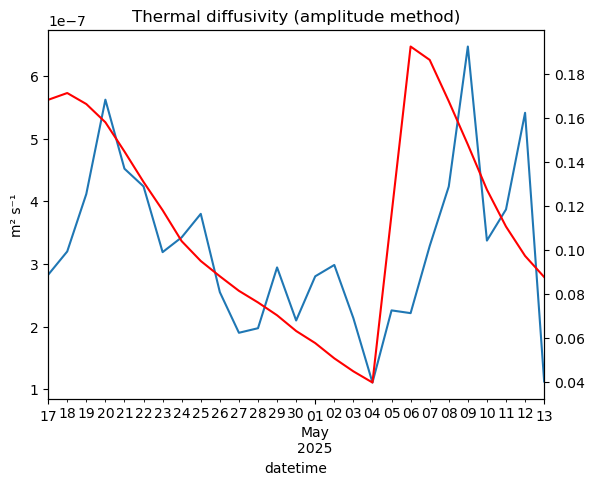

In [22]:
diff['median'].plot(title='Thermal diffusivity (amplitude method)', ylabel='m² s⁻¹')
plt.twinx()
df_grad['VWC05cm'].resample('D').mean().plot(color='red')

<Axes: xlabel='datetime'>

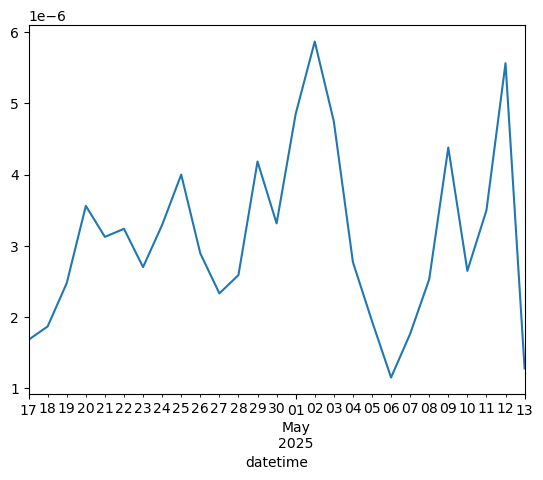

In [23]:
(diff['median']/df_grad['VWC05cm'].resample('D').mean()).plot()

In [24]:
import numpy as np
import pandas as pd
from soil_heat import (diurnal_amplitude, thermal_diffusivity_amplitude)

import numpy as np
import pandas as pd
from soil_heat import diurnal_amplitude, thermal_diffusivity_amplitude

def estimate_rhoc_dry(
    alpha: pd.Series,
    theta: pd.Series,
    porosity: float = 0.40,
    k_dry: float = 0.25, 
    k_sat: float = 1.50,
    rhoc_w: float = 4.18e6,
    dry_quantile: float = 0.10,
) -> float:
    """Return volumetric heat capacity of *dry* soil (J m⁻³ K⁻¹)."""

    # keep only days where both alpha & theta are available
    theta, alpha = theta.align(alpha, join='inner')          # ⬅ key line

    frac_sat = np.clip(theta / porosity, 0.0, 1.0)
    lam = k_dry + (k_sat - k_dry) * frac_sat                 # W m⁻¹ K⁻¹

    # --- 3. Heat capacity & dry-soil estimate ------------------
    Cv = lam / alpha                                         # J m⁻³ K⁻¹
    rhoc_dry = (Cv - theta * rhoc_w) / (1.0 - theta)

    dry_days = theta <= theta.quantile(dry_quantile)
    return float(rhoc_dry.loc[dry_days].median())


In [25]:
alpha_daily = diff['median']
theta_daily = df_grad['VWC05cm'].resample('D').mean()

estimate_rhoc_dry(alpha_daily, theta_daily, porosity=0.40, k_dry=0.25, k_sat=1.50, rhoc_w=4.18e6, dry_quantile=0.10)*1e-6

1.7200303620379673

<Axes: xlabel='datetime'>

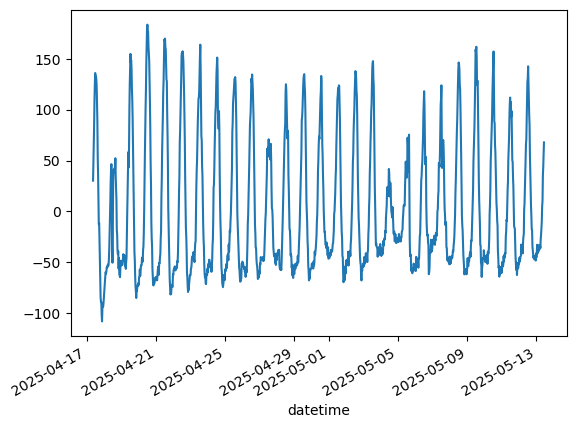

In [26]:
G0 = soil_heat.compute_heat_flux_calorimetric(
    df_grad,
    depth_levels = [0.05, 0.10, 0.20, 0.30],
    T_cols = ['T05cm', 'T10cm', 'T20cm', 'T30cm'],
    theta_cols = ['VWC05cm', 'VWC10cm', 'VWC20cm', 'VWC30cm'],
    C_dry = 1.72e6,
    C_w = 4.2e6,)
G0.plot()

In [27]:
lag_values = pd.concat([soil_heat.diurnal_peak_lag(df_grad['T5cm'], df_grad['T10cm']),
                       soil_heat.diurnal_peak_lag(df_grad['T5cm'], df_grad['T20cm']),
                       soil_heat.diurnal_peak_lag(df_grad['T5cm'], df_grad['T30cm']),],axis=1)
lag_values

KeyError: 'T5cm'

<Axes: xlabel='datetime'>

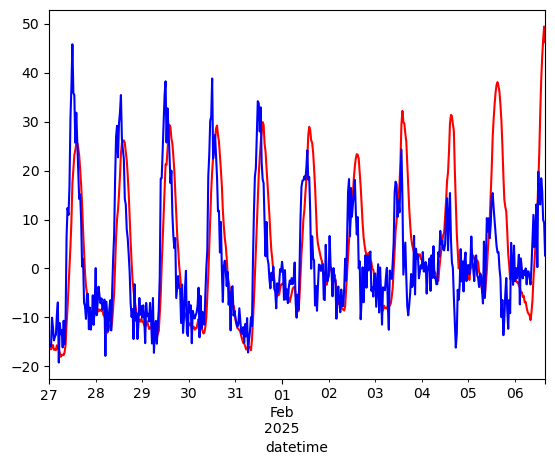

In [ ]:
G0_est.plot(label='G0_est_grad', color='red')
G0_est_2.plot(label='G0_est_calorimetric', color='blue')

In [ ]:
# ---------- Eddy‑covariance flux data ---------------------------------------
# ---------- SoilVUE data ----------------------------------------------------
flux_path_1 = station_path / "e20250513/21314_Flux_AmeriFluxFormat_22.dat"
flux_path_2 = station_path / "e20250513/21314_Flux_AmeriFluxFormat_23.dat"

df_flux_1 = pd.read_csv(flux_path_1, na_values=['NAN'])
df_flux_2 = pd.read_csv(flux_path_2, na_values=['NAN'])
df_flux = pd.concat([df_flux_1, df_flux_2], ignore_index=True)
# Parse timestamp and keep only ground‑heat flux variable ‘G’
df_flux['datetime'] = pd.to_datetime(df_flux['TIMESTAMP_START'].astype(str),
                                     format='%Y%m%d%H%M')

df_flux = df_flux[['datetime', 'G']].dropna(subset=['G']).astype({'G': float})

# Sub‑set to 11 July 2024 (matches the SoilVUE example file)
#mask_0711 = df_flux['datetime'].dt.strftime('%Y%m%d') == '20240711'
#df_flux_0711 = df_flux.loc[mask_0711].set_index('datetime')
#df_flux_0711.head()
df_flux

,datetime,G
0,2025-03-27 23:30:00,-21.953250
1,2025-03-28 00:00:00,8.787329
2,2025-03-28 00:30:00,-7.845843
3,2025-03-28 01:00:00,11.065370
4,2025-03-28 01:30:00,-7.604448
...,...,...
2227,2025-05-13 09:00:00,-36.622820
2228,2025-05-13 09:30:00,-21.398640
2229,2025-05-13 10:00:00,-1.253632
2230,2025-05-13 10:30:00,21.987450


<Axes: xlabel='datetime'>

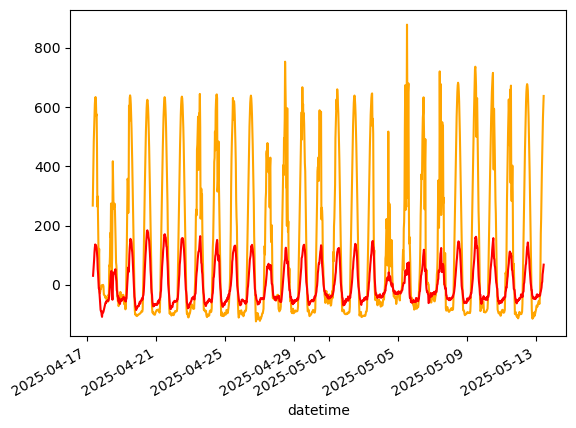

In [ ]:
df_grad['NETRAD'].plot(label='NETRAD', color='orange')
G0.plot(label='G0_est_grad', color='red')



In [ ]:
G0

datetime
2025-04-17 08:06:00          NaN
2025-04-17 08:30:00    30.251806
2025-04-17 09:00:00    46.027718
2025-04-17 09:30:00    66.398487
2025-04-17 10:00:00    84.717237
                         ...    
2025-05-13 09:00:00    10.241025
2025-05-13 09:30:00    35.440317
2025-05-13 10:00:00    43.507711
2025-05-13 10:30:00    56.521603
2025-05-13 11:00:00    67.905579
Name: G_calorimetric, Length: 1255, dtype: float64

In [ ]:
df_NETRAD_G0 = pd.concat([df_grad['NETRAD'], G0], axis=1).dropna()

x = df_NETRAD_G0['NETRAD']
y = df_NETRAD_G0['G_calorimetric']

import statsmodels.api as sm

X = sm.add_constant(x)      # adds intercept term
model = sm.OLS(y, X).fit()  # fit the model
print(model.summary())    

                            OLS Regression Results                            
Dep. Variable:         G_calorimetric   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     7441.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:53:29   Log-Likelihood:                -5817.9
No. Observations:                1254   AIC:                         1.164e+04
Df Residuals:                    1252   BIC:                         1.165e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8550      0.796    -37.527      0.0

<Axes: xlabel='datetime'>

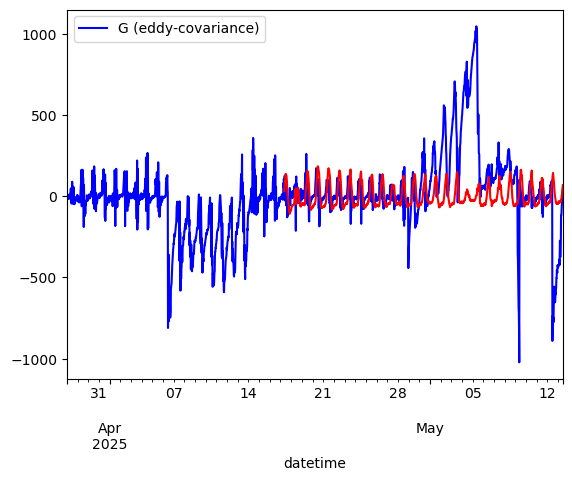

In [ ]:
df_flux.plot(x='datetime', y='G', label='G (eddy‑covariance)', color='blue')
G0.plot(label='G0_est_grad', color='red')

In [ ]:
# Resample the high‑resolution SoilVUE estimates to 30‑min mean
G0_est_30min = G0_est.resample('30min').mean()

# Align indices (inner join)
df_cmp = pd.concat([G0_est_30min, df_flux_0711['G']], axis=1).dropna()
df_cmp.head()


,G_conduction,G
datetime,,
2024-07-11 05:30:00,-26.632568,-97.07862
2024-07-11 06:00:00,-23.820008,-42.72312
2024-07-11 06:30:00,-19.676980,-60.82810
2024-07-11 07:00:00,-14.842567,13.72619
2024-07-11 07:30:00,-6.595578,49.94262


<Axes: xlabel='datetime'>

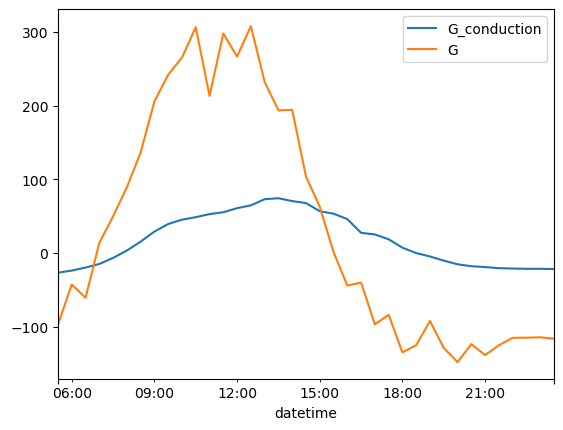

In [ ]:
df_cmp.plot()

In [ ]:
rmse_val = gao.rmse(df_cmp['G0_est_grad'].values, df_cmp['G'].values)
nme_val  = gao.nme(df_cmp['G0_est_grad'].values, df_cmp['G'].values)

print(f'RMSE  = {rmse_val:6.2f} W m⁻²')
print(f'NME   = {nme_val:6.2f} %')


In [ ]:
# ---------- Time‑series overlay --------------------------------------------
plt.figure(figsize=(10, 4))
df_cmp['G0_est_grad'].plot(label='Estimated G₀ (gradient)', lw=1.2)
df_cmp['G'].plot(label='Measured G (plate)', lw=1.2)
plt.axhline(0, color='k', lw=0.4)
plt.ylabel('W m$^{-2}$')
plt.title('11 Jul 2024  •  30‑min surface ground‑heat flux')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Scatter plot ----------------------------------------------------
plt.figure(figsize=(4, 4))
plt.scatter(df_cmp['G'], df_cmp['G0_est_grad'], s=20)
plt.plot([-150, 150], [-150, 150], 'k--', lw=0.7)
plt.xlabel('Measured G (W m$^{-2}$)')
plt.ylabel('Estimated G₀ (W m$^{-2}$)')
plt.title('Gradient method performance')
plt.tight_layout()
plt.show()
